In [1]:
import cv2
import os
import tensorflow as tf
import numpy as np
from google.colab import drive
import smtplib, ssl
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle
import random



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# from google.colab import drive
drive.mount('/content/gdrive')
os.chdir('/content/gdrive/My Drive/fruit/')


Mounted at /content/gdrive


****************************************************
/content/gdrive/My Drive/fruit/color_image.png
BGR values: 
185.08156737305077 198.8353325336532 201.0169932027189
HSV values
[[[ 24  20 201]]]
check for full fn
500 500 3
height filled:  340
std_height :  400.0
amount of bottle filled:  85.0
****************************************************
/content/gdrive/My Drive/fruit/juice_color.jpg
BGR values: 
7.053104575163399 130.77287581699346 239.1846405228758
HSV values
[[[ 16 248 239]]]
check for full fn
275 183 3
height filled:  80
std_height :  220.0
amount of bottle filled:  36.36363636363637
Bottle empty, Skip it 
Groceries  juice


  0%|          | 0/381 [00:00<?, ?it/s]

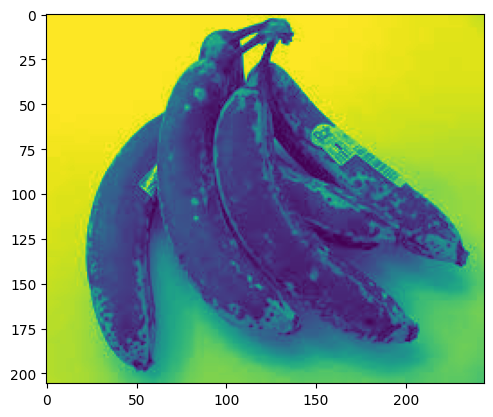

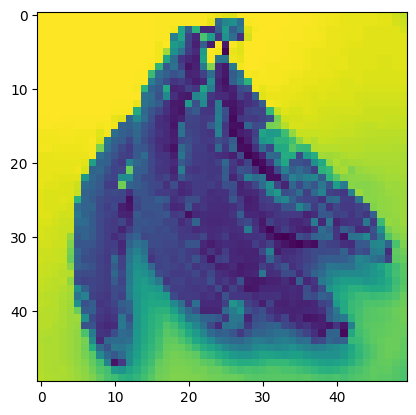

1/1 [==============================] - 0s 221ms/step
[[1.]]
rotten
Content-Type: multipart/alternative; boundary="===============2368506544504416470=="
MIME-Version: 1.0
Subject: Your Grocery List
From: suryapraveen23@gmail.com
To: sadivi@students.kennesaw.edu

--===============2368506544504416470==
Content-Type: text/plain; charset="us-ascii"
MIME-Version: 1.0
Content-Transfer-Encoding: 7bit

  Hi,
  How are you?
  It was quite a busy day it seems. I have few items that you need to purchase for our home. Its time for groceries shopping!!
  here is your list: juice, rotten bananas
--===============2368506544504416470==--



  0%|          | 0/381 [00:02<?, ?it/s]


In [ ]:
# Code to check the quality and quantity of the item
#  and send email alert of groceries list to be purchased by the end user

body=""
sender_email = "suryapraveen23@gmail.com"
# password = 'kojwtyasrwrxhmvy'
password = 'ukmfeqecahomtrrn'


def sendEmailTo(glist, receiver_email):
  
  message = MIMEMultipart("alternative")
  message["Subject"] = "Your Grocery List"
  message["From"] = sender_email
  message["To"] = receiver_email

# Create the plain-text and HTML version of your message
  text = """\
  Hi,
  How are you?
  It was quite a busy day it seems. I have few items that you need to purchase for our home. Its time for groceries shopping!!
  here is your list: """+glist

  # Turn these into plain/html MIMEText objects
  part1 = MIMEText(text, "plain")
  # print(glist)
  # part2 = MIMEText(glist,  'plain')

  # Add HTML/plain-text parts to MIMEMultipart message
  # The email client will try to render the last part first
  message.attach(part1)
  # message.attach(part2)
  print (message)
  # Create secure connection with server and send email
  context = ssl.create_default_context()
  with smtplib.SMTP_SSL("smtp.gmail.com", 465, context=context) as server:
      server.login(sender_email, password)
      server.sendmail(
          sender_email, receiver_email, message.as_string()
      )


# --------------------------------------------------------------------



T_R = -1
T_B = -1
T_G = -1
E_T_R = -1
E_T_B = -1
E_T_G = -1
apr_r = -1
apr_b = -1
apr_g = -1
hsv = -1
lower = []
upper = []
std_height = 1800

""" The function draw_line takes the canny edge-detected image and the original image as inputs, and draws a line on the edges of the bottle.
 It uses the HoughLinesP method from OpenCV to detect the lines on the image. The line that lies in the range of pi/2 ± 0.005 is drawn on the image."""
def draw_line(canny_edges, img):
    
    lines = cv2.HoughLines(canny_edges,1,np.pi/180,100)
    min_l = np.pi/2 - 0.005
    max_l = np.pi/2 + 0.005
    print(lines.shape)
    for line in lines:
        rho = line[0][0]
        theta =  line[0][1]
        if theta <= max_l and theta >= min_l:
            
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a*rho
            y0 = b*rho
            x1 = int(x0 + 1000*(-b))
            y1 = int(y0 + 1000*(a))
            x2 = int(x0 - 1000*(-b))
            y2 = int(y0 - 1000*(a))

            cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)
    return img

"""The function sobel_x takes the original image as input, applies the Sobel operator to it, and shows the resulting image."""

def sobel_x(img):
    sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=3)
    cv2.imshow("img_x", sobelx)
    return sobelx


"""The function dilate_image takes the original image as input, applies a dilation operation to it, and returns the dilated image."""
def dilate_image(img):
    kernel = np.ones((3,3),np.uint8)
    dilate = cv2.dilate(img,kernel,iterations = 1)
    return dilate

"""The function crop_bottle takes the original image as input, applies several image processing techniques to it, 
including Sobel operator, Laplacian, Canny edge detection, dilation, and morphological opening. It then finds the contours of the object in the image, 
selects the contour that corresponds to the bottle, and crops the image to the bounding box of the bottle."""

def crop_bottle(image):
    #sobelx = cv2.Sobel(image,cv2.CV_64F, 1, 0, ksize = 1)
    #sobely = cv2.Sobel(image,cv2.CV_64F, 0, 1, ksize = 1)
    cv2.imshow("laplacian", image)
    laplacian = cv2.Laplacian(image, cv2.CV_64F)
    canny_edges = cv2.Canny(image, 0, 200)
    kernel = np.ones((3,3),np.uint8)
    dilation = cv2.dilate(laplacian,kernel,iterations = 1)
    dilation = np.uint8(dilation)
    #canny_edges = cv2.Canny(dilation, 10, 100)
    cv2.imshow("laplacian", laplacian)
    #opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    
    contours, hierarchy = cv2.findContours(dilation,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)[-2:]
    new_contours = []
    (h, w) = image.shape
    img = cv2.imread("bottle5.jpg")
    for contour in contours:
        if cv2.contourArea(contour)>h*w/20:
            new_contours.append(contour)
    
    cv2.drawContours(img, new_contours, -1, (0,0,255), 3)
    print(len(new_contours))
    cv2.imshow("contours for bottle ",img)
    cv2.waitKey()
    cv2.imshow("contours for bottle ",image)
    
"""This is a Python function that takes an image file path as input, reads the image using the OpenCV library, 
splits the image into its color channels (blue, green, and red), 
calculates the mean value of each channel, converts the mean BGR color to HSV color space using the cv2.cvtColor() function,
 and finally returns the HSV color value."""
 
def find_color_space(img):
    img = cv2.imread(img)
    b, g, r = cv2.split(img)
    b = np.mean(b)
    g = np.mean(g)
    r = np.mean(r)
    print("BGR values: ")
    print(b, g, r)
    li_color = np.uint8([[[b,g,r ]]])
    hsv = cv2.cvtColor(li_color,cv2.COLOR_BGR2HSV)
    print("HSV values")
    print(hsv)
    return hsv

""""cv2.imread" reads grayscale images in OpenCV. Canny edge detection finds picture object edges.
 Morphologically dilates edges with a 5x5 kernel and four iterations. Dilation smooths the edge. 
The application removes the backdrop's small edges from the bottom three rows after dilatation. OpenCV's "cv2.
findContours" method finds the bottle's contours.It removes minor lines and adds bottle shapes. 
The function returns the first filtered contour."""

def crop_bottle_vvt(image_name):
    image = cv2.imread(image_name,0)
    
    #laplacian = cv2.Laplacian(image, cv2.CV_64F)
    canny_edges = cv2.Canny(image, 0, 20)
    
    kernel = np.ones((5,5),np.uint8)
    dilation = cv2.dilate(canny_edges,kernel,iterations = 4)
    dilation = np.uint8(dilation)
    (h, w) = dilation.shape
    print(str(h)+" "+str(w))
    for i in range(w):
        dilation[h-3,i] = 255
        dilation[h-2,i] = 255
        dilation[h-1,i] = 255
        
    cv2.imwrite("dilated.jpg", dilation)
    #canny_edges = cv2.Canny(dilation, 10, 100)
    cv2.imshow("dilated", dilation)
    #opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    
    contours, hierarchy = cv2.findContours(dilation,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)[-2:]
    new_contours = []
    (h, w) = image.shape
    img = cv2.imread(image_name)
    for contour in contours:
        if cv2.contourArea(contour)>h*w/10:
            new_contours.append(contour)
    im2 =  np.zeros((img.shape[0], img.shape[1],3), np.uint8)
    
    cv2.drawContours(img, new_contours, -1, (0,0,255), 3)
    cv2.imwrite("final_image.jpg", img)
    print(len(new_contours))
    return new_contours[0]




"""NumPy's "np.mean" function calculates each color channel's mean intensity. 
The mean intensity value shows each color channel's average pixel brightness.
The function produces a tuple of color channel mean intensity values (T_B, T_G, T_R)."""

def set_intensity_empty(img):
    img = cv2.imread(img)
    print("inside empty")
    b, g, r = cv2.split(img)
    cv2.imshow("hg", b)
    E_T_B = np.mean(b)
    E_T_G = np.mean(g)
    E_T_R = np.mean(r)
    return  E_T_B, E_T_G, E_T_R

""" This function calculates The absolute difference between the expected and 
measured mean intensity values is divided by 2 to produce the approximate threshold value for each color channel.
 This value is saved in "apr_r", "apr_b", and "apr_g" variables for red, blue, and green color channels, respectively."""

def set_apr_values():
    apr_r = abs(E_T_R - T_R)/2
    apr_b = abs(E_T_B - T_B)/2
    apr_g = abs(E_T_G - T_G)/2
    return apr_b, apr_g, apr_r


""" This Functin can determine liquid levels in containers from input images and contour objects.
 However, it implies that the input image is properly preprocessed and segmented to separate the container and liquid within it,
 and that the threshold values are adjusted adequately for the image and lighting conditions."""    
def level_detection(img, contour):
    
    if(apr_r == -1 or apr_g == -1 or apr_b == -1):
        print("First set the values of the threshold")
        return
    
    img = cv2.imread(img)
    x, y, w, h = cv2.boundingRect(contour)
    cv2.imshow("final contour", cv2.drawContours(img, contour, -1, (0,0,255), 3))
    count_liquid = 0
    count_empty = 0
    total_pixel = 0
    print(x, y, w, h)
    
    for i in range(y, y+h):
        for j in range(x, x+w):
             if cv2.pointPolygonTest(contour, (i, j), False) >0 :
                total_pixel = total_pixel + 1           
                if abs(img[i][j][0]-T_B) <= apr_b and abs(img[i][j][0]-T_B) <= apr_b and abs(img[i][j][0]-T_B) <= apr_b:
                    count_liquid = count_liquid+1
                if abs(img[i][j][0]-E_T_B) <= apr_b and abs(img[i][j][0]-E_T_B) <= apr_b and abs(img[i][j][0]-E_T_B) <= apr_b:
                    count_empty = count_empty+1
    
    res = count_liquid/(count_liquid + count_empty)
    print(count_liquid,count_empty, res)
    return res



"""This code defines a function called "main_function_old" that reads an image, 
calibrates it for empty and full bottle, sets some parameter values, 
and detects the liquid level in the bottle using image processing techniques."""  

# read the image
def main_function_old():
    global E_T_R, E_T_B, E_T_G
    global T_R, T_B, T_G
    global apr_r, apr_b, apr_g
    
    if E_T_R == -1 or E_T_B == -1 or  E_T_G == -1:
        print("caliberate empty bottle name of the image:")
        image_name = input()
        E_T_R, E_T_B, E_T_G = set_intensity_empty(image_name)
        print("Updated parameters: ", E_T_B, E_T_G, E_T_R)
    if T_R == -1 or T_B == -1 or  T_G == -1:
        
        print("caliberate full bottle name of the image:")
        image_name = input()
        T_B, T_G, T_R = set_intensity_full(image_name)
        print("Updated parameters: ", T_B, T_G, T_R)
    if apr_r == -1:
        apr_r, apr_b, apr_g = set_apr_values()
    print(apr_r, apr_g, apr_b)
    
    while True :
        print("do you have next image:(y/n):")
        string = input()
        if string == "n":
            break
        print("image name to detect the level:")
        image_name = input()
        contour = crop_bottle_vvt(image_name)
        level_detection(image_name, contour)

"""This function sets the threshold values for color detection in an image by
 finding the color space of a given sample image and defining a 
 range of acceptable color values based on that color space."""

def set_threshold(sample_image):
    print("****************************************************")
    print(sample_image)
    global hsv
    global lower
    global upper
    hsv = find_color_space(sample_image)
    lower = np.array([hsv[0][0][0]-5, hsv[0][0][1]-50, hsv[0][0][2]-50])
    upper = np.array([hsv[0][0][0]+5, hsv[0][0][1]+50, hsv[0][0][2]+50])

"""This function checks if a given bottle image is full or not by analyzing its height and percentage filled, and returns a boolean value. 
It also generates a line on the image to indicate the detected height and saves the results in a file."""

def check_for_full(image_name):
    print("check for full fn")
    global std_height
    
    img = cv2.imread(image_name)
    h, w, c = img.shape
    print(h, w, c)
    std_height = h*80/100
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(img, lower, upper)
    count = 0
    height = 0;
    for i in range(h):
        for j in  range(w):
            if mask[i][j]>=100:
                count = count+1
            if count>50:
                height = i
                break
        if height != 0 :
            break
    img = cv2.imread(image_name)
    img = cv2.line(img, (0,height), (w,height), (0,0,255),10)
    cv2.imwrite("results.jpg", img)
    if height != 0:
        #print("checking", height)
        height = h-height
    percent = (height/std_height)*100
    print("height filled: ",height)
    print("std_height : ", std_height)
    print("amount of bottle filled: ", percent)
    if percent < 80:
        print("Bottle empty, Skip it ")
        return False;
    else:
        return True
    cv2.imwrite("mask.jpg", mask)
    

# ---------------------------------------------------------
"""This is the main function of a program that detects the level of liquid in a bottle using image processing techniques.
It reads the color sample of the liquid and sets the threshold values for image segmentation.
It then checks the level of milk and juice bottles using check_for_full function and
appends the corresponding item names to the 'body' string.Finally, it sends an email containing the grocery list to specified email addresses."""

def main_function():
    global hsv
    global body 
    if hsv == -1:
        # print("Enter the color sample of the liquid\n")
        image_name = '/content/gdrive/My Drive/fruit/color_image.png'
        set_threshold(image_name)
        # print("Input the name of the image or to exit type 'n'")
        image = '/content/gdrive/My Drive/fruit/milkbottel.jpg'
        flag =check_for_full(image)
        if not flag:
          body = body + 'milk '
        # image  = '/content/gdrive/My Drive/fruit/milkbottle_half.jpg'
        # flag =check_for_full(image)
        if not flag:
          body = body + 'milk '
        image_name = '/content/gdrive/My Drive/fruit/juice_color.jpg'
        set_threshold(image_name)
        # print("Input the name of the image or to exit type 'n'")
        image = '/content/gdrive/MyDrive/fruit/juice_half.jpg'
        flag=check_for_full(image)
        if not flag:
          body = body + 'juice'
        print('Groceries ',body)
        # sendEmailTo(body, 'jmhatre1@students.kennesaw.edu')
        # sendEmailTo(body, 'sadivi@students.kennesaw.edu')
        # sendEmailTo(body, 'aturlapa@students.kennesaw.edu')
main_function()
# --------------------------------------
"""The code defines the directory of test dataset and two categories of banana images: fresh and rotten. 
It loads a trained CNN model for image classification and predicts the class of a single banana image by passing it through the model. 
The predicted class is then used to send an email notification with the corresponding label."""

DATADIR = 'dataset/test'
CATAGORIES = ["freshbanana","rottenbanana"]
# ------------------------------------------------------------
"""This code loads a pre-trained deep learning model for image classification and 
uses it to classify an image of a banana as either fresh or rotten. 
The image is preprocessed by converting it to grayscale and resizing it to a fixed size before passing it through the model. 
If the model predicts that the banana is rotten, an email notification is sent with the message "rotten bananas". 
If the prediction is fresh"""

def prepare(filepath):
    IMG_SIZE = 50
    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    plt.imshow(img_array)
    plt.show()
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    plt.imshow(new_array)
    plt.show()

    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

model = tf.keras.models.load_model("onefruit-cnn.model")

# ----------------------------------------------------------------
# from tqdm import tqdm
# import matplotlib.pyplot as plt
count = 1
path = os.path.join(DATADIR,CATAGORIES[0])
for img in tqdm(os.listdir(path)):   
  
  #prediction = model.predict([prepare(os.path.join(path,img))])
  #test your own image
  prediction = model.predict([prepare('rottenBanana.jpg')])
  print(prediction) 
  if int(prediction[0][0]) == 1:
    print("rotten")
    body = body +", rotten bananas"
    sendEmailTo(body, 'sadivi@students.kennesaw.edu')
    # sendEmailTo(body, 'jmhatre1@students.kennesaw.edu')


  else:
    print("fresh")
    # body ="fresh bananas"
    # sendEmailTo(body, 'suryapraveen23@gmail.com')

  
  break
  



In [ ]:
# Below is the code to evaluate the model Accuracy 

In [ ]:
""" This code snippet loads and prepares testing data for a banana image classification model. 
It reads the images from the dataset/test directory, 
creates a list of tuples containing the image arrays and their corresponding labels, shuffles the list,
and then separates the features and labels into X and y arrays. It then converts X into a NumPy array and 
normalizes it by dividing each pixel value by 255.0. The code then saves the X and y arrays to pickle files and 
loads them back for evaluation.Finally, it evaluates the performance of the model on the test data and prints the test loss and accuracy. """

testing_data = []
IMG_SIZE = 50

CATEGORIES = ["freshbanana","rottenbanana"]
def create_testing_data():
    for category in CATEGORIES: 

        path = os.path.join(DATADIR,category)  
        class_num = CATEGORIES.index(category) 

        for img in tqdm(os.listdir(path)): 
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE)) 
                testing_data.append([new_array, class_num])
            except Exception as e:
                pass
           
create_testing_data()


random.shuffle(testing_data)
X = []
y = []
for features,label in testing_data:
    X.append(features)
    y.append(label)

# print(X[0].reshape(-1, IMG_SIZE, IMG_SIZE, 1))

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
# --------------------------------------

pickle_out = open("ATXNS.pickle","wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("atyns.pickle","wb")
pickle.dump(y, pickle_out)
pickle_out.close()

# ----------------------------------------------
pickle_in = open("ATXNS.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("atyns.pickle","rb")
y = pickle.load(pickle_in)

X = X/255.0
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

y = np.array(y)

results = model.evaluate(X, y, batch_size=128)
print('test loss, test acc:', results)
# print(len(testing_data))

100%|██████████| 530/530 [00:12<00:00, 41.22it/s]


8/8 [==============================] - 3s 255ms/step - loss: 0.0418 - accuracy: 0.9846
test loss, test acc: [0.041757982224226, 0.9846322536468506]


In [ ]:
"""This code block appears to be generating predictions for a
 binary classification model that identifies whether an image contains a fresh or rotten banana. 
 The code reads in images from a specified directory and applies the pre-trained model to each image, 
 adding the corresponding prediction to a list.
 The output is a list of strings indicating whether each image contains a fresh or rotten banana. """
from tqdm import tqdm
import matplotlib.pyplot as plt
count = 1
pred = []

for category in CATEGORIES:
  path = os.path.join(DATADIR,category)  
  print(path)
  for img in tqdm(os.listdir(path)):   
    #prediction = model.predict([prepare(os.path.join(path,img))])
    #prediction = model.predict([prepare('samples/fapp.jpg')])
    #print(prediction) 
    if int(prediction[0][0]) == 1:
      pred.append("Rotten Banana")
    else:
      pred.append("Fresh Banana")

dataset/test/freshbanana


100%|██████████| 381/381 [00:00<00:00, 90740.44it/s]


dataset/test/rottenbanana


100%|██████████| 530/530 [00:00<00:00, 553393.36it/s]


In [ ]:
print(pred[:10])


['Rotten Banana', 'Rotten Banana', 'Rotten Banana', 'Rotten Banana', 'Rotten Banana', 'Rotten Banana', 'Rotten Banana', 'Rotten Banana', 'Rotten Banana', 'Rotten Banana']


In [ ]:
""" The code loads and preprocesses testing data from a directory containing fresh and rotten banana images. 
It then evaluates the performance of a pre-trained convolutional neural network model on the
 testing data and prints the test loss and accuracy.
 Finally, it generates predicted and actual labels for the testing data and stores them in separate lists. """
import random

#random.shuffle(testing_data)
X = []
y = []
actual = []
import numpy as np
for features,label in testing_data:
    X.append(features)
    y.append(label)
print(y[900:])
for i in y:
  if i == 1:
      actual.append("Rotten Banana")
  else:
      actual.append("Fresh Banana")
print(actual[:10])

[0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0]
['Rotten Banana', 'Fresh Banana', 'Fresh Banana', 'Fresh Banana', 'Rotten Banana', 'Fresh Banana', 'Rotten Banana', 'Rotten Banana', 'Fresh Banana', 'Fresh Banana']


In [ ]:
"""This code creates a pandas DataFrame named df using two lists, actual and pred,
 which contain the actual and predicted fruit labels for a dataset of banana images. 
 The DataFrame has two columns, "Actual Fruit" and "Predicted Fruit", and each row represents a single image. 
 The pd.DataFrame() function takes in a dictionary where the keys represent column names and the values represent the data in each column. 
Finally, the DataFrame is printed out."""
import csv
import pandas as pd

fruits = {'Actual Fruit': actual,
        'Predicted Fruit': pred
        }

df = pd.DataFrame(fruits, columns= ['Actual Fruit', 'Predicted Fruit'])

In [ ]:
pd.set_option('display.max_rows', None)
df.head(n=100)


,Actual Fruit,Predicted Fruit
0,Rotten Banana,Rotten Banana
1,Fresh Banana,Rotten Banana
2,Fresh Banana,Rotten Banana
3,Fresh Banana,Rotten Banana
4,Rotten Banana,Rotten Banana
5,Fresh Banana,Rotten Banana
6,Rotten Banana,Rotten Banana
7,Rotten Banana,Rotten Banana
8,Fresh Banana,Rotten Banana
9,Fresh Banana,Rotten Banana


In [ ]:
# The `df` DataFrame has been saved as a CSV file named "ClassifiedFruits.csv" in the "/content/sample_data/" directory.
df.to_csv("/content/sample_data/ClassifiedFruits.csv")
